# Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning.

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a scipt you can download and import into your notebooks (or elsewhere).

We've done this for some of the functions we've used precously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-02-28 22:47:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-28 22:47:57 (69.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

**Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_functions.py`, so you'll have to redownload it if you want access to your helper functions.

## Let's get some data

This time we're going to see how we can use the pretrained models within tf.keras.applications and apply them to our own problem (recognizing images of food)

In [ ]:
# Get 10% of training data of 100 classes
# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
unzip_data("10_food_classes_10_percent.zip")


--2023-02-28 22:48:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  21.6MB/s    in 8.3s    

2023-02-28 22:48:10 (19.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
from os import walk
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [ ]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[2.11658173e+02 1.72658173e+02 1.29658173e+02]
   [2.27117355e+02 1.90025513e+02 1.46071442e+02]
   [2.27357147e+02 1.93571426e+02 1.48571426e+02]
   ...
   [2.49918381e+02 1.54285751e+02 4.94949265e+01]
   [2.49311218e+02 1.59688828e+02 5.29285965e+01]
   [2.49586716e+02 1.64556168e+02 5.61428909e+01]]

  [[2.15688782e+02 1.74163254e+02 1.28591843e+02]
   [2.24061218e+02 1.85928574e+02 1.40862259e+02]
   [2.25729599e+02 1.89556122e+02 1.44500000e+02]
   ...
   [2.45857162e+02 1.46000015e+02 3.44438744e+01]
   [2.45275528e+02 1.49372467e+02 3.77806473e+01]
   [2.45785675e+02 1.52188843e+02 4.18571777e+01]]

  [[2.19801025e+02 1.75785706e+02 1.26433670e+02]
   [2.23785721e+02 1.81658173e+02 1.33158173e+02]
   [2.26045914e+02 1.88306122e+02 1.41260208e+02]
   ...
   [2.47260193e+02 1.43428574e+02 2.79234562e+01]
   [2.47000000e+02 1.42770401e+02 2.93877602e+01]
   [2.44933640e+02 1.42076508e+02 3.15714283e+01]]

  ...

  [[1.48928543e+02 1.55505112e+02 1.92647995e+02]
   [1

## Model 0: Building a transfer learning model using the Kras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models.

In [ ]:
from os.path import dirname
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNet)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save the history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])

16705208/16705208 [==============================] - 2s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230228-224822


Epoch 1/5
24/24 [==============================] - 20s 247ms/step - loss: 1.8620 - accuracy: 0.4533 - val_loss: 1.2789 - val_accuracy: 0.7549
Epoch 2/5
24/24 [==============================] - 4s 137ms/step - loss: 1.0845 - accuracy: 0.7867 - val_loss: 0.8619 - val_accuracy: 0.8273
Epoch 3/5
24/24 [==============================] - 5s 198ms/step - loss: 0.7913 - accuracy: 0.8253 - val_loss: 0.7075 - val_accuracy: 0.8322
Epoch 4/5
24/24 [==============================] - 4s 173ms/step - loss: 0.6464 - accuracy: 0.8627 - val_loss: 0.6200 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 4s 175ms/step - loss: 0.5399 - accuracy: 0.8853 - val_loss: 0.5592 - val_accuracy: 0.8586


In [ ]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 88ms/step - loss: 0.5590 - accuracy: 0.8636


[0.55901700258255, 0.8636000156402588]

In [ ]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [ ]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


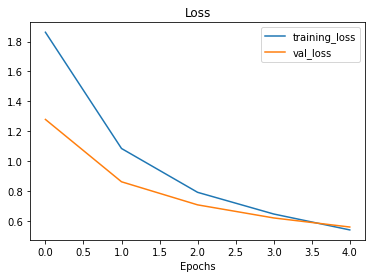

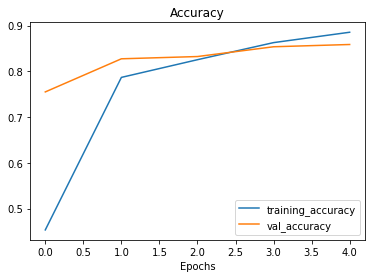

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let' demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass ti to GlobalAveragePooling2D.

In [ ]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [ ]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation.
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation.
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation.

**Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics

## Getting and processing data for model_1

In [ ]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2023-02-28 22:49:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  23.4MB/s    in 6.5s    

2023-02-28 22:49:29 (19.6 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"

In [ ]:
# How many images are we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'

In [ ]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir_1_percent,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

Off the top of our heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rathar than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotation, zoom, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescale(1./255) # Keep for models like ResNet50v2 but EfficientNet's having rescaling built in
], name="data_augmentation")

### Visualiz our data augmentation layer (and see what happens to our data)

(-0.5, 384.5, 540.5, -0.5)

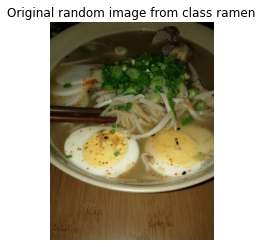

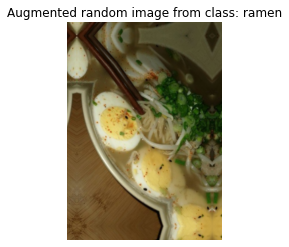

In [ ]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(img, training=True)
plt.figure()
plt.imshow(augmented_img/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [ ]:
# Setup input shape and base model, frezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230228-224936
Epoch 1/5


3/3 [==============================] - ETA: 0s - loss: 2.4179 - accuracy: 0.0714

3/3 [==============================] - 16s 2s/step - loss: 2.4179 - accuracy: 0.0714 - val_loss: 2.2783 - val_accuracy: 0.1086
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1700 - accuracy: 0.2000 - val_loss: 2.1586 - val_accuracy: 0.2023
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9402 - accuracy: 0.3429 - val_loss: 2.0344 - val_accuracy: 0.2845
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.7678 - accuracy: 0.5143 - val_loss: 1.9297 - val_accuracy: 0.3569
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6257 - accuracy: 0.6143 - val_loss: 1.8252 - val_accuracy: 0.4046


In [ ]:
# Check out a model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 67ms/step - loss: 1.8263 - accuracy: 0.4108


[1.8262660503387451, 0.4108000099658966]

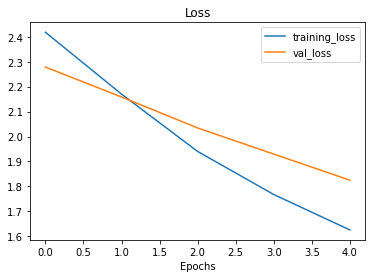

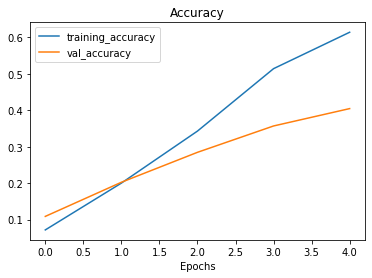

In [ ]:
# How do the model with 1% of the data augmentation loss curves look?
plot_loss_curves(history_1_percent)

## Model 2: feature extraction transfer learning model with 10% data and data augmentation

In [ ]:
# Get 10% data...
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
# Set data inputs
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Creat the inputs and outputs (includeing the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # augment our training images (augmentation on test data)
x = base_model(x, training=False) # pass the augmented images to base model but keep it in inference mode, this also ensures batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
x = keras.layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 224, 3)     0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 output_layer (Dense)        (None, 10)                1281

### Creating a ModelCheckPoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training  This is useful so we can come and start where we left off.

In [ ]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", # Save at each epoch
                                                         verbose=1)

### Fit model 2 passing in the ModelCheckpoint callback

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230228-225026
Epoch 1/5


24/24 [==============================] - ETA: 0s - loss: 2.0386 - accuracy: 0.3173
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 26s 637ms/step - loss: 2.0386 - accuracy: 0.3173 - val_loss: 1.4854 - val_accuracy: 0.6414
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3353 - accuracy: 0.6973
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 416ms/step - loss: 1.3353 - accuracy: 0.6973 - val_loss: 1.0447 - val_accuracy: 0.7944
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0246 - accuracy: 0.7573
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 415ms/step - loss: 1.0246 - accuracy: 0.7573 - val_loss: 0.8246 - val_accuracy: 0.8273
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.8636 - accuracy: 0.8027
Epoch

In [ ]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 79ms/step - loss: 0.5590 - accuracy: 0.8636


[0.5590168833732605, 0.8636000156402588]

In [ ]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 7s 78ms/step - loss: 0.6404 - accuracy: 0.8388


[0.6404469609260559, 0.8388000130653381]

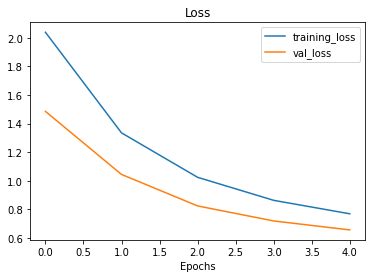

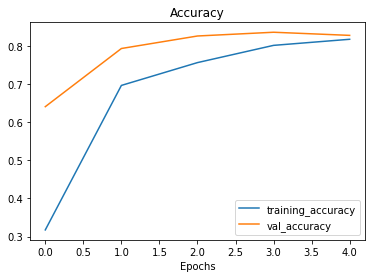

In [ ]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint.



In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 76ms/step - loss: 0.6404 - accuracy: 0.8388


In [ ]:
# If the results from our previously evaluated model_2 match the loaded weights, everything has worked

In [ ]:
results_10_percent_data_aug == loaded_weights_model_results

False

In [ ]:
results_10_percent_data_aug

[0.6404469609260559, 0.8388000130653381]

In [ ]:
loaded_weights_model_results

[0.6404469013214111, 0.8388000130653381]

In [ ]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[5.96046448e-08 0.00000000e+00]


## Model 3: Fine-tuning an existing model on 10% of the data

**Note:** Fine-tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data.

In [ ]:
# Layers in loaded model
model_2.layers

In [ ]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f9ddc26d0d0> True
<keras.engine.sequential.Sequential object at 0x7f9de1fda2e0> True
<keras.engine.functional.Functional object at 0x7f9de1c83580> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f9dea1aa430> True
<keras.layers.reshaping.flatten.Flatten object at 0x7f9de15df3a0> True
<keras.layers.core.dense.Dense object at 0x7f9de1ba99d0> True


In [ ]:
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine-tuning you typically want to lower the learning rate by 10x
                metrics=["accuracy"])

**Note:** When using fine-tuning, it's best practice to lower your learning rate by some amount.  How much?  This is a hyperparameter you can tune.  But a good rule of thumb is at least 10x (though different sources will claim other values).

A good resource on this is the ULM Fit paper


In [ ]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(model_2.trainable_variables))

12


In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start training from previous last epoch
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230228-225201


Epoch 5/10


24/24 [==============================] - 24s 430ms/step - loss: 0.6587 - accuracy: 0.8133 - val_loss: 0.4885 - val_accuracy: 0.8602
Epoch 6/10
24/24 [==============================] - 8s 309ms/step - loss: 0.5135 - accuracy: 0.8493 - val_loss: 0.4815 - val_accuracy: 0.8503
Epoch 7/10
24/24 [==============================] - 8s 340ms/step - loss: 0.4444 - accuracy: 0.8667 - val_loss: 0.4400 - val_accuracy: 0.8684
Epoch 8/10
24/24 [==============================] - 9s 354ms/step - loss: 0.4216 - accuracy: 0.8733 - val_loss: 0.4337 - val_accuracy: 0.8635
Epoch 9/10
24/24 [==============================] - 7s 280ms/step - loss: 0.3807 - accuracy: 0.8827 - val_loss: 0.4105 - val_accuracy: 0.8668
Epoch 10/10
24/24 [==============================] - 8s 292ms/step - loss: 0.3331 - accuracy: 0.8920 - val_loss: 0.4047 - val_accuracy: 0.8635


In [ ]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 8s 91ms/step - loss: 0.4435 - accuracy: 0.8520


In [ ]:
results_10_percent_data_aug

[0.6404469609260559, 0.8388000130653381]

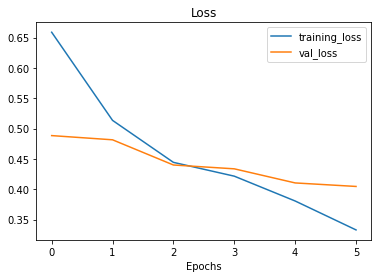

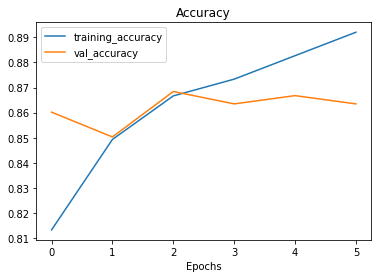

In [ ]:
# Check out the loss curves of our fine tune model
plot_loss_curves(history_fine_10_percent_data_aug)

The plot_loss_curves function works great with models which have only been fit once, however, we want something to compare one series of running fit() with another (e.g. before and after fine-tuning)

In [ ]:
# Let's create a function to compare training histories
def compare_histories(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow History objects.
  """
  # Get original history measurements

  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plots Accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.xlabel(xlabel="epochs")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

    # Make plots Loss
  plt.figure(figsize=(8,8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.xlabel(xlabel="epochs")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")


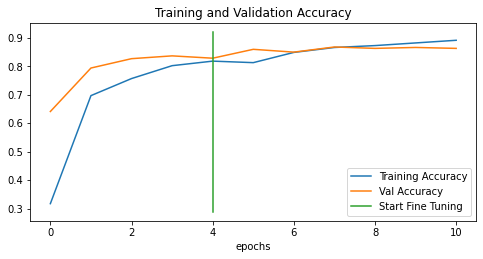

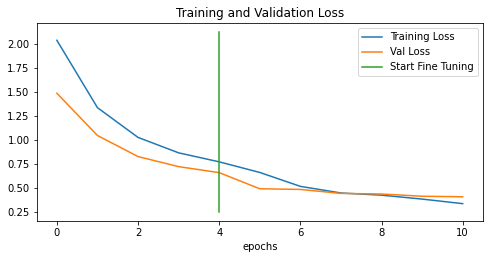

In [ ]:
compare_histories(history_10_percent_data_aug,
                  history_fine_10_percent_data_aug,
                  initial_epochs=5)

## Model 4: Fine-tuning an existing model on all of the data

In [ ]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2023-02-28 22:53:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

a.zip                79%[==============>     ] 392.16M  22.8MB/s    eta 5s     

In [ ]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [ ]:
# How many images are we working with now
walk_through_dir("10_food_classes_all_data")

In [ ]:
# Setup data inputs
import tensorflow
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

The test dataset we've loaded in is the same as what we've been using for previous experiments (all experiments have used the same test dataset).

Let's verify this...

In [ ]:
# Evaluate model 2 (this is the fine-tuned 10 percet of data version)
model_2.evaluate(test_data)

In [ ]:
results_fine_tune_10_percent

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights.

In [ ]:
# Loadweights from checkpoints, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
model_2.load_weights("/content/ten_percent_model_checkpoints_weights/checkpoint.ckpt.index")

In [ ]:
checkpoint_path

In [ ]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

In [ ]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

ALright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using ModleCHeckpoint callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3)
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2 except this timewe're going to use all the data (model 4).

In [ ]:
# Check which layers tunavle in the whol model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

In [ ]:
# Let's drill into our base_model (efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

In [ ]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [ ]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                      experiment_name="full_10_classes_fine_tune_last_10")])

In [ ]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

In [ ]:
# How did fine-tuning go withmore data?
compare_histories(original_history=history_10_percent_data_aug,
                  new_history=history_fine_10_classes_full,
                  initial_epochs=5)

## Viewing our experiment data on TensorBoard

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should be ~4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
--name "Transfer Learning Experiments with 10 Food101 Classes" \
--description "A series of different transfer learning experiments with varying amouns of data and fine-tuning" \
--one_shot # exits the uploader once its finished uploading

My TensorBoard experiments are available at: https://tensorboard.dev/experiment/bCkVKXUZQjij4ASlBMZkMw/

In [ ]:
!tensorboard dev list